**Long Short-Term Memory** networks are a type of RNN designed to specifically address the challenges of capturing long-term dependencies in sequential data. Stock price prediction is a sequential task, where past trends and patterns significantly influence future prices. 
LSTMs excel in retaining relevant historical information while **discarding** unnecessary data. So they are well-suited for dealing with time-series problems.

In [15]:
%pip install torch torchvision pandas numpy matplotlib scikit-learn

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/203.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/203.0 MB 5.6 MB/s eta 0:00:36
    --------------------------------------- 2.9/203.0 MB 8.0 MB/s eta 0:00:26
   - -------------------------------------- 5.2/203.0 MB 9.1 MB/s eta 0:00:22
   - -------------------------------------- 7.9/203.0 MB 10.1 MB/s eta 0:00:20
   -- ------------------------------------- 10.7/203.0 MB 11.0 MB/s eta 0:00:18
   -- ------------------------------------- 13.9/203.0 MB 11.8 MB/s eta 0:00:17
   --- ------------------------------------ 18.1/203.0 MB 13.1 MB/s eta 0:00:15
   ---- ----------------------------------- 22.5/203.0 MB 14.3 MB/s eta 0:00:13
   ----- ---------------------------------- 27.3/203.0 MB 15.2 MB/s eta 0:00:12
   ------ ------------

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load and preprocess
data = pd.read_csv("../GOOGL_stock_data.csv")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

# Scale the close prices
scaler = MinMaxScaler()
data["Close_scaled"] = scaler.fit_transform(data[["Close"]])

# Sequence length
seq_length = 60  # Look-back period

# Sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return sequences

# Splitting
train_split_date = "2022-01-01"
train_data = data[data["Date"] < train_split_date]["Close_scaled"].values
test_data = data[data["Date"] >= train_split_date]["Close_scaled"].values

In [29]:
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)

# Convert to PyTorch tensors
X_train = torch.tensor([s[0] for s in train_sequences], dtype=torch.float32)
y_train = torch.tensor([s[1] for s in train_sequences], dtype=torch.float32)
X_test = torch.tensor([s[0] for s in test_sequences], dtype=torch.float32)
y_test = torch.tensor([s[1] for s in test_sequences], dtype=torch.float32)

# Reshape for LSTM input (batch_size, seq_length, input_size)
X_train = X_train.view(X_train.shape[0], seq_length, 1)
X_test = X_test.view(X_test.shape[0], seq_length, 1)

C:\Users\siwma\AppData\Local\Temp\ipykernel_35656\1305609963.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train = torch.tensor([s[0] for s in train_sequences], dtype=torch.float32)


In [30]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM output
        out = self.fc(out[:, -1, :])  # Fully connected layer
        return out

In [31]:
# Initialize the model, loss function, and optimizer
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Training loop
epochs = 50
train_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred.view(-1), y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

Epoch 1/50, Loss: 0.10807973891496658
Epoch 2/50, Loss: 0.09795493632555008
Epoch 3/50, Loss: 0.08861429989337921
Epoch 4/50, Loss: 0.07999150454998016
Epoch 5/50, Loss: 0.07199829816818237
Epoch 6/50, Loss: 0.06460680812597275
Epoch 7/50, Loss: 0.057820744812488556
Epoch 8/50, Loss: 0.05164061114192009
Epoch 9/50, Loss: 0.046055443584918976
Epoch 10/50, Loss: 0.04110413417220116
Epoch 11/50, Loss: 0.03678469359874725
Epoch 12/50, Loss: 0.03348374739289284
Epoch 13/50, Loss: 0.031009890139102936
Epoch 14/50, Loss: 0.02976636402308941
Epoch 15/50, Loss: 0.02999942936003208
Epoch 16/50, Loss: 0.030918311327695847
Epoch 17/50, Loss: 0.03230702131986618
Epoch 18/50, Loss: 0.03350603207945824
Epoch 19/50, Loss: 0.03350892663002014
Epoch 20/50, Loss: 0.032597459852695465
Epoch 21/50, Loss: 0.03140091150999069
Epoch 22/50, Loss: 0.030285673215985298
Epoch 23/50, Loss: 0.028956016525626183
Epoch 24/50, Loss: 0.027971727773547173
Epoch 25/50, Loss: 0.02727699838578701
Epoch 26/50, Loss: 0.02669

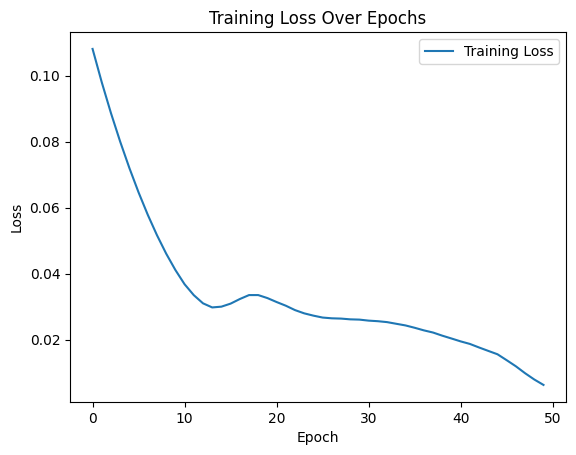

In [33]:
# Plot training loss
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

In [34]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).view(-1).numpy()
    y_test_np = y_test.numpy()

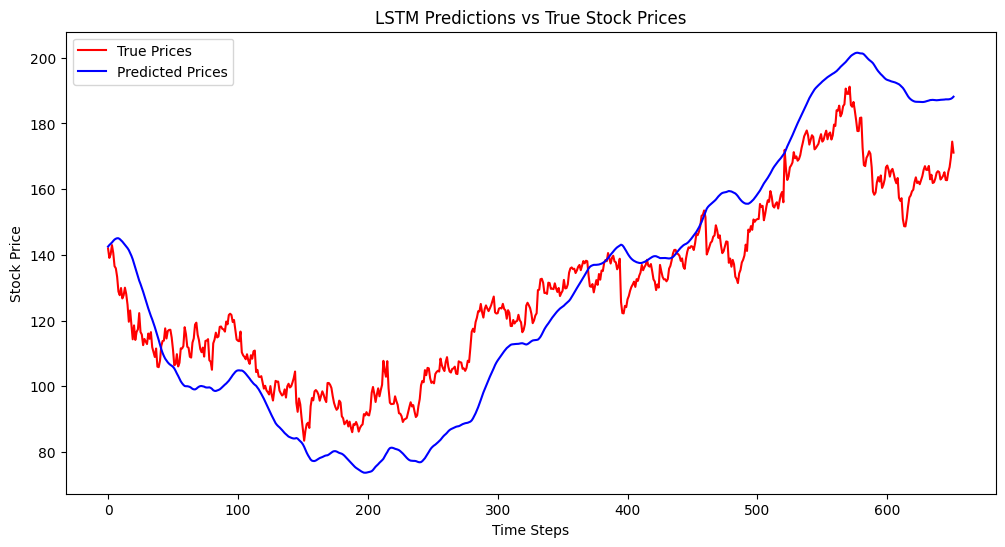

Model saved.


In [35]:
# Invert scaling for predictions and true values
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_np = scaler.inverse_transform(y_test_np.reshape(-1, 1))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_np, label="True Prices", color="red")
plt.plot(y_pred, label="Predicted Prices", color="blue")
plt.title("LSTM Predictions vs True Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), "lstm_model.pth")
print("Model saved.")

LSTM and GRU are similar in a way, but you could call GRU more "simplified". So both models are capable of learning the stock price trend, but GRU appears to outperform LSTM in this context. Looks like it can capture rapid changes and adapts better to price fluctuations, making it more suitable for stock price prediction in this **specific dataset.**